## <big> <b> Section 0: </b> Define Methods </big> 

In [1]:
import math
import pyfasta
import torch
from torch import nn
import numpy as np
import pandas as pd
import h5py
import random
import matplotlib.pyplot as plt



genome = pyfasta.Fasta('../../data/hg19.fa')


def encode_seq(seq):
    """
    returns an encoded sequence 
    
    Args:
        seq: 2000bp sequence
    
    Returns:
        4 x 2000 np.array

    """

    #encode the sequence
    mydict = {'A': np.asarray([1, 0, 0, 0]), 'G': np.asarray([0, 1, 0, 0]),
            'C': np.asarray([0, 0, 1, 0]), 'T': np.asarray([0, 0, 0, 1]),
            'N': np.asarray([0, 0, 0, 0]), 'H': np.asarray([0, 0, 0, 0]),
            'a': np.asarray([1, 0, 0, 0]), 'g': np.asarray([0, 1, 0, 0]),
            'c': np.asarray([0, 0, 1, 0]), 't': np.asarray([0, 0, 0, 1]),
            'n': np.asarray([0, 0, 0, 0]), '-': np.asarray([0, 0, 0, 0])}
    

    #each column is the encoding for each nucleotide in the original seq
    seq_encoded = np.zeros((4, len(seq)))
    for i in range(len(seq)):
        #this implements the encoding
        seq_encoded[:,i] = mydict[seq[i]]


        
    return torch.from_numpy(seq_encoded)

def encoding_to_sequence(x):
    ret_string = ""
    for i in range(2000):
        if x[ 0, i] == 1:
            ret_string += "a"
            
        elif x[ 1, i] == 1:
            ret_string += "g"
            
            
        elif x[ 2, i] == 1:
            ret_string += "c"
            
            
        elif x[ 3, i] == 1:
            ret_string += "t"
        
        else:
            print("none change")

            
    return ret_string


## <big> <b> Section 1: </b> data setup </big> 

a) save sequences

In [2]:
df = pd.read_csv("../../data/experimental/DNasedata.csv")
ref_seqs = []
alt_seqs = []


for i in range(len(df["CHR"])):
    CHR = df["CHR"][i]
    POS = df["POS"][i]
    seq = genome.sequence({'chr': CHR, 'start': POS - 999 , 'stop': POS + 1000})
    ref_seqs.append(seq)
    
    alt_seq = seq[:999] + df["ALT"][i] + seq[1000:]
    alt_seqs.append(alt_seq)
    
torch.save(ref_seqs, "./DNaseData/ref_seqs")    
torch.save(alt_seqs, "./DNaseData/alt_seqs")               


b) save encoded versions of the sequence

In [3]:
encoded_alt_seqs = []
encoded_ref_seqs = []

for i in range(len(alt_seqs)):
    encoded_ref_seq = encode_seq(ref_seqs[i])
    encoded_alt_seq = encode_seq(alt_seqs[i])
    
    
    encoded_ref_seqs.append(encoded_ref_seq)
    encoded_alt_seqs.append(encoded_alt_seq)
    
    
torch.save(encoded_alt_seqs, "./DNaseData/encoded_alt_seqs")
torch.save(encoded_ref_seqs, "./DNaseData/encoded_ref_seqs")

c) save reverse complement of the encoded sequence

In [5]:
encoded_refs = torch.load("./DNaseData/encoded_ref_seqs")
encoded_alts = torch.load("./DNaseData/encoded_alt_seqs")  

encoded_refs_reverse_comps = []
encoded_alts_reverse_comps = []
for i in range(len(encoded_refs)):
    ref_revcomp = encoded_refs[i].numpy()[::-1,::-1]
    alt_revcomp = encoded_alts[i].numpy()[::-1,::-1]
    encoded_refs_reverse_comps.append(torch.from_numpy(ref_revcomp.copy()))
    encoded_alts_reverse_comps.append(torch.from_numpy(alt_revcomp.copy()))

    
torch.save(encoded_refs_reverse_comps, "./DNaseData/encoded_refs_reverse_comps")
torch.save(encoded_alts_reverse_comps, "./DNaseData/encoded_alts_reverse_comps")

<big><big><big><big> <b>  Section 2: Plot Results </b> </big></big></big></big>

Run this section AFTER running the getPreds.py file

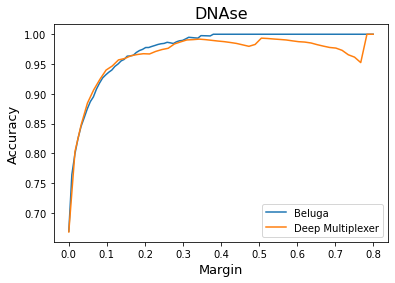

In [7]:
import matplotlib.pyplot as plt
import torch
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


DNASE_beluga_dict =  torch.load("./DNaseData/Beluga_accuracy_dict")
DNASE_BI_dict = torch.load("./DNaseData/BM_accuracy_dict")


plt.plot( DNASE_beluga_dict["margins"], DNASE_beluga_dict["accuracy"], label="Beluga")
plt.plot( DNASE_BI_dict["margins"], DNASE_BI_dict["accuracy"], label="Deep Multiplexer")
plt.legend()
plt.xlabel("Margin", fontsize = 13)
plt.ylabel("Accuracy", fontsize = 13)
plt.title("DNAse", fontsize = 16)
plt.savefig('DNAse.pdf', bbox_inches = 'tight')  

